In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import random

In [2]:
class Node:
    def __init__(self):
        self.parent = None
        self.label = ""

    def evaluation(self, input_variables):
        pass

    def __str__(self):
        pass

class NTerminal(Node):
    def __init__(self):
        super().__init__()  # Invoke parent class constructor
        self.values = None

    def evaluation(self, input_variables):
        return self.values

    def __str__(self):
        return str(self.label)

class NFunction(Node):
    def __init__(self):
        super().__init__()  # Invoke parent class constructor
        self.label = None
        self.leftChild = None
        self.rightChild = None

    def evaluation(self, input_variables):
        if self.label == '+':
            return self.leftChild.evaluation(input_variables) + self.rightChild.evaluation(input_variables)
        if self.label == '-':
            return self.leftChild.evaluation(input_variables) - self.rightChild.evaluation(input_variables)
        if self.label == '*':
            return self.leftChild.evaluation(input_variables) * self.rightChild.evaluation(input_variables)

    def __str__(self):
        return f"({self.leftChild.__str__()} {self.label} {self.rightChild.__str__()})"

class Individual:
    def __init__(self):
        self.root = None

    def evaluation(self, input_variables):
        return self.root.evaluation(input_variables)



In [3]:
class GPAlgorithm:
    def __init__(self,maxit, stopFitn, input_variables, name_variables,target_values,  verbose=False, popsize = 100):
        self.verbose = verbose
        self.popsize = popsize
        self.input_variables = input_variables
        self.name_variables = name_variables
        self.target_values = target_values
        self.population = None
        self.popFitness = np.zeros(popsize)
        self.elite = None
        self.elitefitness = None
        self.maxit = maxit
        self.stopFitn = stopFitn
    
    def new_individual(self, level=0):
        if not level == 0 and (level >= 2 or np.random.rand() <= 0.5):
            node = NTerminal()
            if np.random.rand() <= 0.5:
                n_variables = self.input_variables.shape[1]
                i = np.random.randint(n_variables)
                node.label = self.name_variables[i]
                node.values = self.input_variables[:, i]
            else:
                i = np.random.randint(10)
                node.label = str(i)
                node.values = i
        else:
            node = NFunction()
            node.label = np.random.choice(['+', '-', '*'])
            node.leftChild = self.new_individual(level + 1)
            node.rightChild = self.new_individual(level + 1)
        return node

    def init_population(self):
        population = []
        for i in range(self.popsize):
            ind = Individual()
            ind.root = self.new_individual()
            population.append(ind)
            #print(f'Individual {i}: {ind.root}')
        return population
    
    def print_population(self):
        for i in range(self.popsize):
            print(i,": ", self.population[i].root, "; f; ", self.popFitness[i])
    
    
    def fitness_function(self, individual):
        predicted_values = [individual.evaluation(inputs) for inputs in self.input_variables]
        mae = np.mean(np.abs(self.target_values - predicted_values))
        return mae
    
    def _update_elite(self):
        best_index = np.argmin(self.popFitness)
        best_individual = self.population[best_index]

        if self.elite is None or self.popFitness[best_index] < self.elitefitness:
            self.elite = copy.deepcopy(best_individual)
            self.elitefitness = self.popFitness[best_index]
                
    def _stop_condition(self,k):
        if k >= self.maxit or self.elitefitness <= self.stopFitn:
            return True
        return False
        
    def _bin_tournament(self):
        rnd = np.random.randint(0, self.popsize, 2)
        if(self.popFitness[rnd[0]] < self.popFitness[rnd[1]] ):
            return rnd[0]
        return rnd[1]
    
    def _traverse(self, node, nodes):
        if isinstance(node, NFunction):
            nodes.append(node)
            self._traverse(node.leftChild, nodes)
            self._traverse(node.rightChild, nodes)
        elif isinstance(node, NTerminal):
            nodes.append(node)

    def _traverse_for_functions(self, node, function_nodes):
        if isinstance(node, NFunction):
            function_nodes.append(node)
            self._traverse_for_functions(node.leftChild, function_nodes)
            self._traverse_for_functions(node.rightChild, function_nodes)
    
    def _crossover(self, p1, p2):
        # Make a copy of the parents' trees to perform crossover
        ind1 = copy.deepcopy(self.population[p1])
        ind2 = copy.deepcopy(self.population[p2])

        # Randomly select nodes in each parent for crossover
        node_parent1 = self._select_random_node(ind1.root)
        node_parent2 = self._select_random_node(ind2.root)

        # Check if both nodes are NFunction nodes before crossover
        if isinstance(node_parent1, NFunction) and isinstance(node_parent2, NFunction):
            # Create a new individual for the offspring
            new_ind = Individual()
            new_ind.root = copy.deepcopy(ind1.root)  # Set one parent's tree as the starting point

            # Perform the crossover by swapping the selected nodes between parents
            new_ind.root.leftChild, new_ind.root.rightChild = node_parent2.leftChild, node_parent2.rightChild

            return new_ind

        # Return the original individual if crossover conditions are not met
        return ind1  # or return ind2, based on the requirements


    def _select_random_node(self, root):
        # Helper function to select a random node in the tree
        nodes = []  # Store nodes for random selection
        self._traverse(root, nodes)
        return random.choice(nodes)

            
    def _mutation(self, ind):
        mutated_ind = copy.deepcopy(ind)  # Create a copy for mutation

        # Choose between subtree mutation and point mutation randomly
        #mutation_type = np.random.choice(['subtree', 'point'])
        mutation_type = 'subtree'
        if mutation_type == 'subtree':
            # Perform subtree mutation
            node_to_mutate = self._select_random_node(mutated_ind.root)
            if isinstance(node_to_mutate, NFunction):  # Ensure it's a function node
                node_to_mutate.leftChild = self.new_individual()
                node_to_mutate.rightChild = self.new_individual()
        else:
            # Perform point mutation (changing a function node)
            node_to_mutate = self._select_random_function_node(mutated_ind.root)
            if node_to_mutate:
                node_to_mutate.label = np.random.choice(['+', '-', '*'])

        return mutated_ind
        
    def _select_random_function_node(self, root):
        # Helper function to select a random function node in the tree
        function_nodes = []
        self._traverse_for_functions(root, function_nodes)
        return random.choice(function_nodes) if function_nodes else None


    def _negative_tournament(self):
         return np.argmax(self.popFitness)
         
    def _print_elite(self):
        print(self.elite.root, "; f; ", self.elitefitness)
        
    def solve(self):
        # Initialize the population
        self.population = self.init_population()

        # Evaluate the fitness of each individual and print the MAE
        for i, ind in enumerate(self.population):
            self.popFitness[i] = self.fitness_function(ind)
            
        self._update_elite()
        
        k=0
        while not self._stop_condition(k):
            p1 = self._bin_tournament()
            p2 = self._bin_tournament()
            
            new_ind = self._crossover(p1,p2)
            mutated_ind = self._mutation(new_ind)
            
            oldIdx = self._negative_tournament()
            
            self.population[oldIdx] = copy.deepcopy(mutated_ind)
            self.popFitness[oldIdx] = self.fitness_function(mutated_ind)
            
            self._update_elite()
            if self.verbose:
                self._print_elite()
        return {'success':True,'sol':self.elite, 'niter':k, 'fitness':self.elitefitness}  
        
        

# Main

In [4]:
# Load data from 'data.csv'
df = pd.read_csv('data.csv')
name_variables =  ['X1', 'X2']
input_variables = df[['X1', 'X2']].values
target_values = df['Y'].values

GP = GPAlgorithm(5000, 0.1, input_variables, name_variables,target_values,  verbose=True, popsize = 100)
res = GP.solve()

(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
(X1 * X1) ; f;  6493.987158100943
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) 

((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 + X2) - 8)) ; f;  215.51342526049027
((X1 * (3 * X1)) + ((X1 

((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.2

((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.2

((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.26438655720005
((X1 * (3 * X1)) + (((6 + X2) * 5) - ((8 - 1) * 6))) ; f;  100.2

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) 

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) 

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) 

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) 

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - ((3 + 0) - (X2 * 4)))) ; f;  100.10750479845557
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) 

((X1 * (3 * X1)) + ((((1 + X1) - 7) - ((2 - (6 + X2)) - ((8 + 0) - 1))) - ((3 + 0) - (X2 * 4)))) ; f;  50.053752465665546
((X1 * (3 * X1)) + ((((1 + X1) - 7) - ((2 - (6 + X2)) - ((8 + 0) - 1))) - ((3 + 0) - (X2 * 4)))) ; f;  50.053752465665546
((X1 * (3 * X1)) + ((((1 + X1) - 7) - ((2 - (6 + X2)) - ((8 + 0) - 1))) - ((3 + 0) - (X2 * 4)))) ; f;  50.053752465665546
((X1 * (3 * X1)) + ((((1 + X1) - 7) - ((2 - (6 + X2)) - ((8 + 0) - 1))) - ((3 + 0) - (X2 * 4)))) ; f;  50.053752465665546
((X1 * (3 * X1)) + ((((1 + X1) - 7) - ((2 - (6 + X2)) - ((8 + 0) - 1))) - ((3 + 0) - (X2 * 4)))) ; f;  50.053752465665546
((X1 * (3 * X1)) + ((((1 + X1) - 7) - ((2 - (6 + X2)) - ((8 + 0) - 1))) - ((3 + 0) - (X2 * 4)))) ; f;  50.053752465665546
((X1 * (3 * X1)) + ((((1 + X1) - 7) - ((2 - (6 + X2)) - ((8 + 0) - 1))) - ((3 + 0) - (X2 * 4)))) ; f;  50.053752465665546
((X1 * (3 * X1)) + ((((1 + X1) - 7) - ((2 - (6 + X2)) - ((8 + 0) - 1))) - ((3 + 0) - (X2 * 4)))) ; f;  50.053752465665546
((X1 * (3 * X1)) + ((((1

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - (X2 + 5))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  2.000000144863834
((X1 * (

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4)))) ; f;  1.9999998551361664
((X1 * (3 * X1)) + ((((1 + X1) - 7) - (X1 - ((X2 + (3 * 3)

In [5]:
#cruza, mutacion, seleccion, fitness... implementar el fitness...
#es una regresion: coeficiente de determinacion o error medio absoluto, la suma de las diferencias absolutas entre el valor qeu tengo contra el valor predicho 

In [7]:
print(res['sol'].root)

((X1 * (3 * X1)) + (((((8 * 1) + ((X1 - 8) - 1)) - 7) - (X1 - ((X2 + (3 * 3)) + ((2 * 6) * (X1 - X1))))) - (((8 - X1) + ((2 - 9) - X1)) - (X2 * 4))))


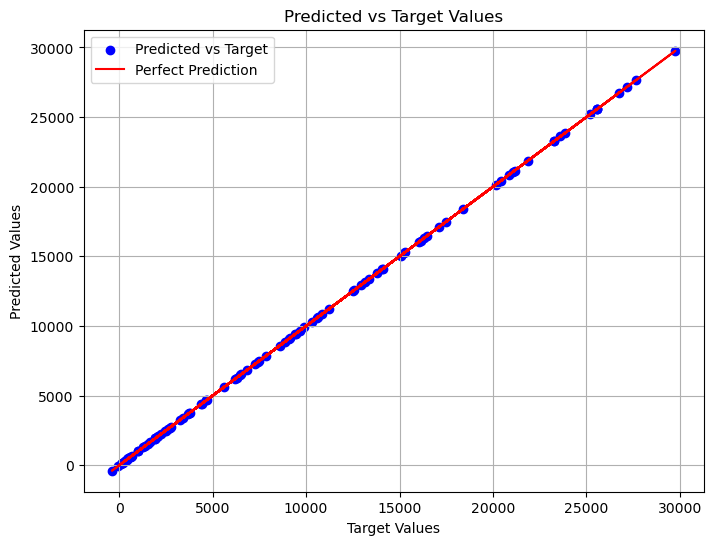

In [15]:
# 1. Evaluate the solution with input variables
predicted_values = res['sol'].evaluation(input_variables)

# 2. Visualize the prediction against target values
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(target_values, predicted_values, color='blue', label='Predicted vs Target')
plt.plot(target_values, target_values, color='red', label='Perfect Prediction')
plt.xlabel('Target Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Target Values')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
print(predicted_values)

[ 2001.9798667  12504.78432457  1931.25542787 14070.34395887
   153.1380137  21067.68492351  1021.89839397  1389.12817978
  1913.34603102 29761.93532896  6288.46004679 20134.70063169
 25589.86774988 23263.12126835  6192.25814485  9667.38974105
  1520.57432764 10621.88378221  7473.65226253 13779.8038652
 10304.57994302 25551.02680538   -71.41006356 23604.46339822
  1294.89175272  4662.09969749  9910.547756   27677.09781887
   435.12457715  3396.57857073   489.97553995 11246.20198483
 17131.82691983 14109.04804459 23863.16506436  6542.47903302
 16134.57853986  3777.5703802  25548.60090293 20422.56967918
 12928.72050243  1637.01341352 10591.00573796 10857.94633283
   994.0062956  15218.64262062  9412.78087632   174.82577064
  2232.35991361 13147.18359506  6492.20939847 25191.78895469
 26755.5117251  12587.29127696  9156.46257421  3734.81071569
 15054.03033929  4714.58655382  2489.92595541 16299.0570204
  3251.35303837  9081.8818766  20833.92654081   107.85795923
  5625.55014236  2767.1600